In [1]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import time

import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import decoder_files_to_tensors, get_best_model_timestamp
from utils import unnormalize_params, assess_decoder
from models import Decoder, mse_loss_encoder, mse_loss_decoder


2022-09-20 17:21:14.664623: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-20 17:21:14.700086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-20 17:21:14.700098: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Initialize parameters
data_dir = '/eos/kiliakis/tomo_data/datasets'


# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)

# First the training data
files = glob.glob(TESTING_PATH + '/*.pk')

import time
start_t = time.time()
# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_test, y_test = decoder_files_to_tensors(files)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(files):.3f}')

VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
assert os.path.exists(VALIDATION_PATH)

# Then the validation data
files = glob.glob(VALIDATION_PATH + '/*.pk')

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_valid, y_valid = decoder_files_to_tensors(files)



2022-09-20 17:21:17.267485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-20 17:21:17.267509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 17:21:17.267523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-09-20 17:21:17.268461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 160.447, Per file: 0.116


In [8]:
# Model to load
# timestamp = '2022_09_19_17-34-47'
timestamp = get_best_model_timestamp('./trials', model='dec')
print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

# load the model
decoder = keras.models.load_model(os.path.join(weights_dir, 'decoder.h5'))


2022_09_20_16-20-04


In [9]:
# Evaluate the model on the test and validation data
test_loss = decoder.evaluate(x_test, y_test)
print(f'Test loss: {test_loss:.4e}')

# get predictions
test_pred = decoder.predict(x_test, verbose=False)
y_test = np.array(y_test)

# Calculate error per variable
# mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')

valid_loss = decoder.evaluate(x_valid, y_valid)
print(f'Valid loss: {valid_loss:.4e}')
valid_pred = decoder.predict(x_valid, verbose=False)

44/44 [==============================] - 5s 106ms/step - loss: 6.0858e-04
Test loss: 6.0858e-04
37/37 [==============================] - 4s 106ms/step - loss: 5.9888e-04
Valid loss: 5.9888e-04


1.0
-1.0


Text(0.5, 1.0, 'Mean Diff.')

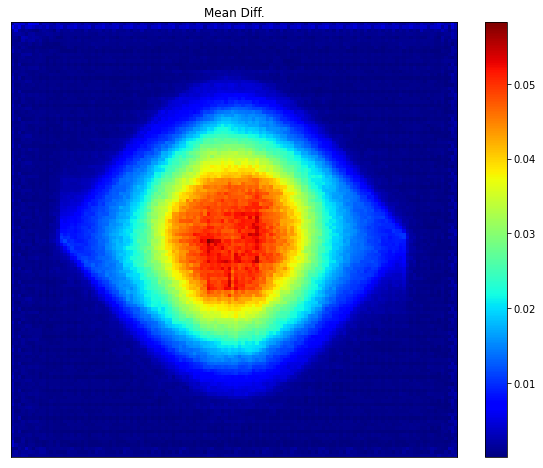

In [10]:
%matplotlib inline

print(np.max(y_test))
print(np.min(y_test))
mse_image = np.mean((y_test - test_pred) ** 2, axis=0)
mse_image = mse_image.reshape((128, 128))

me_image = np.mean(np.abs(y_test - test_pred), axis=0)
me_image = me_image.reshape((128, 128))

# Create 3x3 grid of figures
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))

ax.set_xticks([])
ax.set_yticks([])
# show the image
plt.imshow(me_image, cmap='jet', aspect='auto')
plt.colorbar()
# Set the label
# title = ','.join([f'{num:.1f}' for num in samples_X[i]])
ax.set_title(f'Mean Diff.')

# for i in range(len(axes)):
#     ax = axes[i]


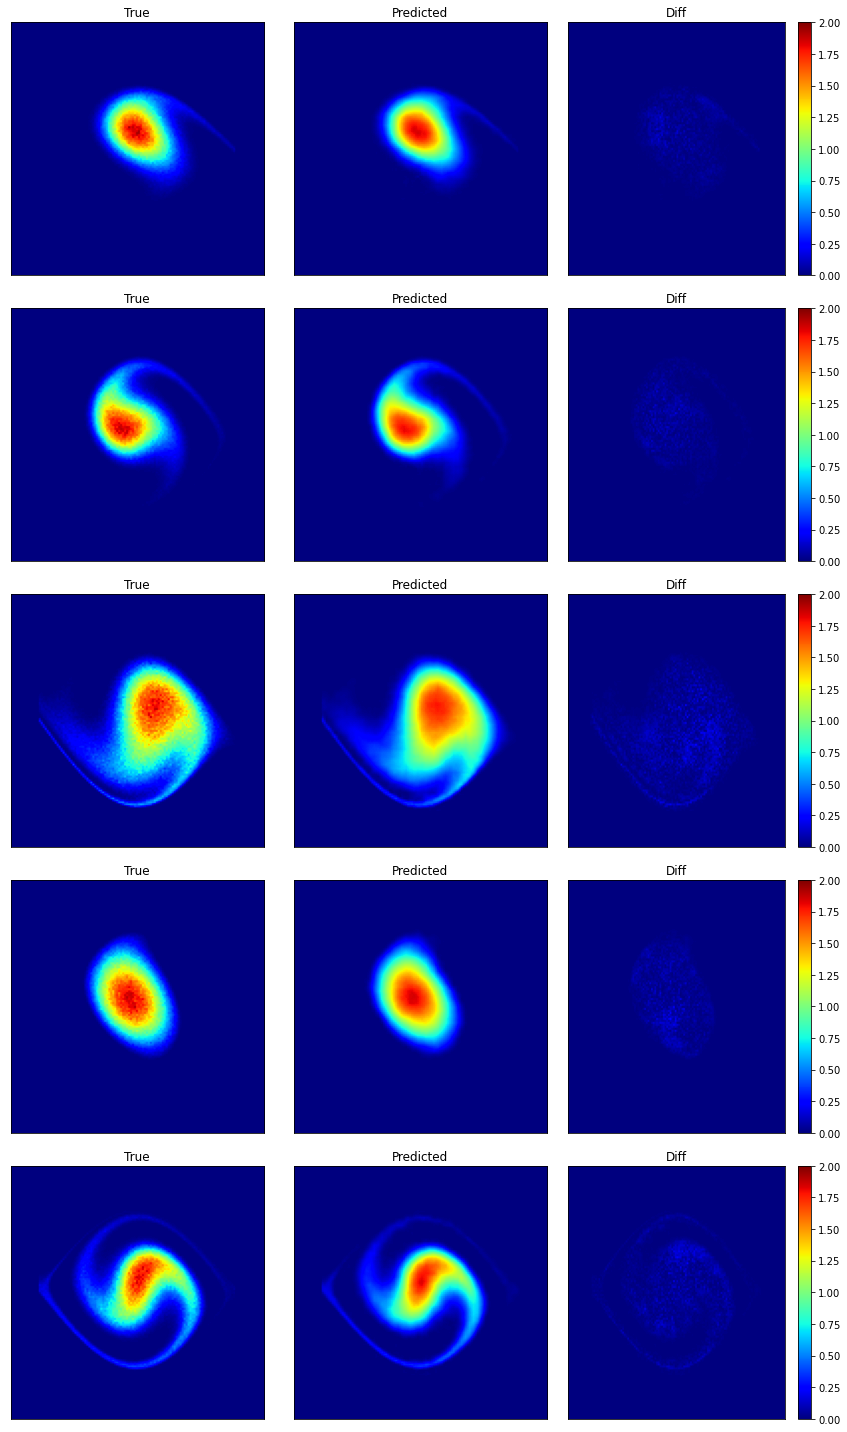

In [12]:
%matplotlib inline
# plot some of the outputs

nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(y_test)),
                          size=nrows, replace=False)

samples_real = y_test[sample]
samples_pred = test_pred[sample]

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 20))
# axes = np.ravel(axes)
for i in range(nrows):
    ax = axes[i][0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_real[i]+1, cmap='jet', vmin=0, vmax=2)
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'True')
    plt.tight_layout()

    ax = axes[i][1]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_pred[i]+1, cmap='jet', vmin=0, vmax=2)
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Predicted')
    plt.tight_layout()

    ax = axes[i][2]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    plt.imshow(np.abs(samples_real[i] -
              samples_pred[i]), cmap='jet', vmin=0, vmax=2,
              aspect='auto')
    plt.colorbar()
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Diff')
    plt.tight_layout()
